# Toxic comment detection using SVM and different vectorization features

In [1]:
import re
import numpy as np
import scipy
import scipy.sparse as sp
import pandas as pd
import pickle
from sklearn import svm
from sklearn.metrics import roc_auc_score
from nltk.sentiment import SentimentIntensityAnalyzer
from collections import defaultdict
from nltk.tokenize import word_tokenize
import nltk
import time
import matplotlib.pyplot as plt
from nltk import ngrams
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /home/krise/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/krise/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/krise/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

Code based on https://github.com/bmeaut/python_nlp_2018_spring/blob/master/course_material/14_Semantics_II/14_Semantics_2_lab.ipynb

In [16]:
#Custom featurizer calss

class Featurizer():
    sa = SentimentIntensityAnalyzer()
    feature_functions = []
    
    @staticmethod
    def bag_of_words(text):
        for word in word_tokenize(text):
            yield (word, None)

    @staticmethod
    def pos_tags(text):
        word_tag_tuples = nltk.pos_tag(word_tokenize(text))
        tag_count_dict = {}
        for word_tag_tuple in word_tag_tuples:
            if(word_tag_tuple[1] in tag_count_dict.keys()):
                tag_count_dict[word_tag_tuple[1]] += 1
            else:
                tag_count_dict[word_tag_tuple[1]] = 1

        for tag in tag_count_dict:
            yield (tag, tag_count_dict[tag])

    @staticmethod
    def vader_sentiment(text):
        sentiments = Featurizer.sa.polarity_scores(text)
        for key in sentiments:
            yield("vader " + key, sentiments[key])

    @staticmethod
    def word_ngrams(text):
        for ngram in ngrams(word_tokenize(text), 2):
            yield (" ".join(ngram), None)

    @staticmethod
    def pos_ngrams(text):
        n = 2
        tokens = word_tokenize(text)

        l = len(tokens)
        word_tag_tuples = nltk.pos_tag(tokens)
        for x in range(0, l - n + 1):
            pos_ngram = ""
            for i in range(0, n):
                pos_ngram += word_tag_tuples[x + i][1] + " "
            yield (pos_ngram, None)    

    #Either start completely new feature/id dictionaries if only features of this featurizer will be used
    #or base dictionary on that of a different featurizer so they can be used together
    def __init__(self, foreign_features = None):
        if (foreign_features == None): #Will create standalone dictionaries
            self.features = {}
            self.features_by_id = {}
            self.next_feature_id = 0
            self.max_foreign_feature = 0
        else: #Some other vectorizer will be used in addition to this one
            self.features = foreign_features
            self.features_by_id = {v: k for k, v in foreign_features.items()}
            self.next_feature_id = max(foreign_features.values()) + 1
            self.max_foreign_feature = self.next_feature_id

    def to_sparse(self, events):
        """convert sets of ints to a scipy.sparse.csr_matrix"""
        data, row_ind, col_ind = [], [], []
        for event_index, event in enumerate(events):
            for feature, value in event:
                if (value != None):
                    data.append(value)
                else:
                    data.append(1)
                    
                row_ind.append(event_index)
                col_ind.append(feature - self.max_foreign_feature)

        n_features = len(self.features.keys()) - self.max_foreign_feature
        n_events = len(events)
        matrix = scipy.sparse.csr_matrix(
            (data, (row_ind, col_ind)), shape=(n_events, n_features))
        return matrix

    def featurize(self, dataset, allow_new_features=False, verbose = False):
        events, labels = [], []
        n_events = len(dataset)
        for c, (text, label) in enumerate(dataset):
            if (verbose):
                if c % 10000 == 0:
                    print("{0:.0%}...".format(c/n_events), end='')
            labels.append(label)
            events.append(set())
            for function_name in Featurizer.feature_functions:
                function = getattr(Featurizer, function_name)
                for feature, value in function(text):
                    if feature not in self.features:
                        if not allow_new_features:
                            continue
                        self.features[feature] = self.next_feature_id
                        self.features_by_id[self.next_feature_id] = feature
                        self.next_feature_id += 1
                    feat_id = self.features[feature]
                    events[-1].add((feat_id, value))
                    
        #print(events[1])            
        events_sparse = self.to_sparse(events)
        #print(events_sparse[1])
        labels_array = np.array(labels)
        print('done!')

        return events_sparse, labels_array

    def get_feature_names(self):
        return list([k for k, v in sorted(self.features.items(), key=lambda item: item[1])])
    
    def get_featurname_to_id_dict(self):
        return self.features
        
    def get_id_to_featurname_dict(self):
        return self.features_by_id
        
    #merge feature matrices of this featurizer and a different featurizer
    def merge_feature_matrices(self, foreign_matrix, inherent_matrix):
        return sp.hstack([foreign_matrix, inherent_matrix])
    
    def print_sample_with_feature_names(self, feature_matrix, sample_id):
        sample = feature_matrix.getrow(sample_id)
        nonzero_idxs = sample.nonzero()[1]
        for idx in nonzero_idxs:
            print(self.features_by_id[idx].rjust(30, ' ') , ":" , sample.getcol(idx).toarray()[0][0])

In [3]:
# function for plotting most important features for SVM (works only for linear kernel)
def plot_coefficients(classifier, feature_names, top_features=20):
    #feature_names*=3
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(-coef)[:top_features]
    top_negative_coefficients = np.argsort(-coef)[-top_features:]
    top_coefficients = np.hstack([top_positive_coefficients, top_negative_coefficients])
    # create plot
    plt.figure(figsize=(3, 10))
    colors = ['green' if c < 0 else 'red' for c in coef[top_coefficients]]
    plt.barh(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.yticks(np.arange(0,2 * top_features), feature_names[top_coefficients], ha='right')
    plt.show()

In [4]:
def evaluate(predictions, dev_labels, valid_df, model, featurizer):
    stats_by_label = defaultdict(lambda: defaultdict(int))
    if (isinstance(predictions, np.ndarray)):
        predictions = predictions.tolist()
    for i, gold in enumerate(dev_labels):
        auto = predictions[i]
        # print(auto, gold)
        if auto == gold:
            stats_by_label[auto]['tp'] += 1
        else:
            stats_by_label[auto]['fp'] += 1
            stats_by_label[gold]['fn'] += 1

    print("{:>8} {:>8} {:>8} {:>8} {:>8} {:>8}".format(
        'label', 'n_true', 'n_tagged', 'precision', 'recall', 'F-score'))
    for label, stats in stats_by_label.items():
        all_tagged = stats['tp'] + stats['fp']
        stats['prec'] = stats['tp'] / all_tagged if all_tagged else 0
        all_true = stats['tp'] + stats['fn']
        stats['rec'] = stats['tp'] / all_true if all_true else 0
        stats['f'] = (2 / ((1/stats['prec']) + (1/stats['rec']))
                      if stats['prec'] > 0 and stats['rec'] > 0 else 0)

        print("{:>8} {:>8} {:>8} {:>8.2f} {:>8.2f} {:>8.2f}".format(
            label, all_true, all_tagged, stats['prec'], stats['rec'],
            stats['f']))

    accuracy = (
        sum([stats_by_label[label]['tp'] for label in stats_by_label]) /
        len(predictions)) if predictions else 0

    av_rec = sum([stats['rec'] for stats in stats_by_label.values()]) / 3
    f_pn = (stats_by_label['positive']['f'] +
            stats_by_label['negative']['f']) / 2

    print()
    print("{:>10} {:>.4f}".format('Acc:', accuracy))
    print("{:>10} {:>.4f}".format('P/N av. F:', f_pn))
    print("{:>10} {:>.4f}".format('Av.rec:', av_rec))
    print("{:>10} {:>.4f}".format('AUC :', roc_auc_score(predictions, dev_labels)))
    
    incorrectly_classified_msk = [ x != y for (x,y) in zip(predictions, list(valid_df['target']))]
    correctly_classified_msk = [not x for x in incorrectly_classified_msk]
    incorrectly_classified = valid_df[incorrectly_classified_msk]
    correctly_classified = valid_df[correctly_classified_msk]
    
    incorrectly_classified_ambig = incorrectly_classified.loc[(incorrectly_classified['toxicity'] > 0.4)\
                                                              & (incorrectly_classified['toxicity'] < 0.6)] 
    print("From", len(incorrectly_classified), "incorrectly classified,", len(incorrectly_classified_ambig),\
          "are ambiguous", "(", len(incorrectly_classified_ambig) / len(incorrectly_classified) *100, "%)")
    
    incorrectly_classified.loc[(incorrectly_classified['toxicity'] <= 0.4)\
                                | (incorrectly_classified['toxicity'] >= 0.6)].head(100).to_csv("examples/incorrect.csv")
    correctly_classified.loc[(correctly_classified['toxicity'] <= 0.4)\
                                | (incorrectly_classified['toxicity'] >= 0.6)].head(100).to_csv("examples/correct.csv")
    print("saved (non-ambiguous) examples for correctly and incorrectly classified comments to /examples" )
    
    plot_coefficients(model, featurizer.get_feature_names())

Reading in data with pandas

In [5]:
fields = ['comment_text', 'toxicity','target']

#train_df = pd.read_csv("data/pre_processed/subsets/25_percent/spellcorrect_tresh10/train_lemma_nopunct_spellcorrect_thresh_10.csv", usecols = fields)
train_df = pd.read_csv("data/pre_processed/subsets/25_percent/train_lemma_nopunct_cleaned_sentencized.csv", usecols = fields)
train_df.dropna(inplace = True)
#train_df = train_df[:100]
#valid_df = pd.read_csv("data/pre_processed/subsets/25_percent/spellcorrect_thresh5/valid_lemma_nopunct_spellcorrect.csv", usecols = fields)
valid_df = pd.read_csv("data/pre_processed/subsets/25_percent/valid_lemma_nopunct_cleaned_sentencized.csv", usecols = fields)
valid_df.dropna(inplace = True)
#valid_df = valid_df[:100]

train = list(zip(list(train_df['comment_text']), list(train_df['target'])))
valid = list(zip(list(valid_df['comment_text']), list(valid_df['target'])))

In [6]:
def train_and_evaluate(train_events, train_labels, valid_events, valid_labels, valid_df, featurizer):
    print('training...')
    start = time.time()
    model = svm.LinearSVC()
    model.fit(train_events, train_labels)
    end = time.time()
    print("Training took:", int((end-start)), "sec")

    start = time.time()
    predicted_labels = model.predict(valid_events)
    end = time.time()
    print("Predicting took:", int((end-start)), "sec")

    evaluate(predicted_labels, valid_labels, valid_df, model, featurizer)
    return featurizer, train_events, train_labels, valid_events, valid_labels, predicted_labels, model

In [7]:
def vectorize_train_evaluate(train, valid, valid_df, verbose = False):
    print('featurizing train...')
    featurizer = Featurizer()
    start = time.time()
    train_events, train_labels = featurizer.featurize(train, allow_new_features=True, verbose = verbose)
    print('featurizing valid...')
    valid_events, valid_labels = featurizer.featurize(valid, allow_new_features=False, verbose = verbose)
    end = time.time()
    print("Vectorizing took:", int((end-start)), "sec")
    
    return train_and_evaluate(train_events, train_labels, valid_events, valid_labels, valid_df, featurizer)

Testing performance for one-hot encoding word occurences for each comment

featurizing train...
0%...3%...6%...8%...11%...14%...17%...19%...22%...25%...28%...30%...33%...36%...39%...42%...44%...47%...50%...53%...55%...58%...61%...64%...66%...69%...72%...75%...78%...80%...83%...86%...89%...91%...94%...97%...100%...done!
featurizing valid...
0%...11%...22%...33%...44%...55%...66%...78%...89%...100%...done!
Vectorizing took: 241 sec
training...


/home/krise/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Training took: 33 sec
Predicting took: 0 sec
   label   n_true n_tagged precision   recall  F-score
       1    10925    10332     0.83     0.79     0.81
       0    79345    79938     0.97     0.98     0.97

      Acc: 0.9556
P/N av. F: 0.0000
   Av.rec: 0.5893
     AUC : 0.9029
From 4011 incorrectly classified, 1046 are ambiguous ( 26.078284717028172 %)
saved (non-ambiguous) examples for correctly and incorrectly classified comments to /examples


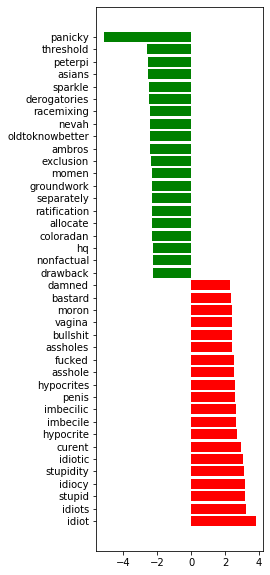

In [8]:
Featurizer.feature_functions = ['bag_of_words']

res = vectorize_train_evaluate(train, valid, valid_df, verbose = True)
pickle.dump(res, open("featurized_data/bow.p", "wb" ))

TFIDF should generally be a better vectorized representation of a comment than just word occurences, as it also takes word frequency in the comment relative to the rest of the corpus into account.

Checking if TFIDF vectorization will improve performance:

training...
Training took: 3 sec
Predicting took: 0 sec
   label   n_true n_tagged precision   recall  F-score
       1    10925     9780     0.87     0.78     0.82
       0    79345    80490     0.97     0.98     0.98

      Acc: 0.9595
P/N av. F: 0.0000
   Av.rec: 0.5882
     AUC : 0.9210
From 3653 incorrectly classified, 1052 are ambiguous ( 28.798248015329865 %)
saved (non-ambiguous) examples for correctly and incorrectly classified comments to /examples


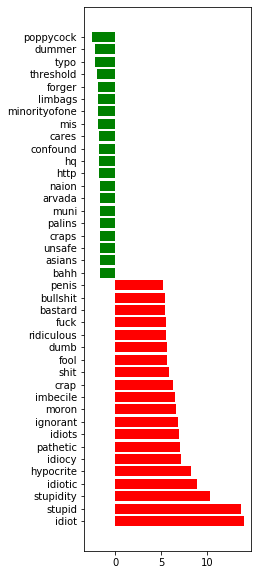

In [9]:
tfidf_vectorizer = TfidfVectorizer() #Using NTLKs tfidf vectorizer

tfidf_train = tfidf_vectorizer.fit_transform(train_df['comment_text'])
target_train = list(train_df["target"])
tfidf_valid = tfidf_vectorizer.transform(valid_df['comment_text'])
valid_train = list(valid_df["target"])

res = train_and_evaluate(tfidf_train, target_train, tfidf_valid, valid_train, valid_df, tfidf_vectorizer)

So far, the approaches were based on word occurences/counts and completely lost the information of in what sequence words appear. We can try using ngrams to retain some context.

training...
Training took: 5 sec
Predicting took: 0 sec
   label   n_true n_tagged precision   recall  F-score
       1    10925     9831     0.88     0.79     0.83
       0    79345    80439     0.97     0.99     0.98

      Acc: 0.9616
P/N av. F: 0.0000
   Av.rec: 0.5921
     AUC : 0.9255
From 3466 incorrectly classified, 1040 are ambiguous ( 30.005770340450088 %)
saved (non-ambiguous) examples for correctly and incorrectly classified comments to /examples


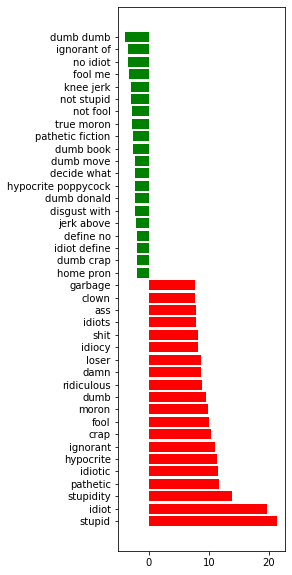

In [10]:
#Testing showed that there seems to be no improvement when using more than bigrams
tfidf_vectorizer = TfidfVectorizer(ngram_range = (1,2))

tfidf_train = tfidf_vectorizer.fit_transform(train_df['comment_text'])
target_train = list(train_df["target"])
tfidf_valid = tfidf_vectorizer.transform(valid_df['comment_text'])
valid_train = list(valid_df["target"])

res = train_and_evaluate(tfidf_train, target_train, tfidf_valid, valid_train, valid_df, tfidf_vectorizer)

array([1])

In [17]:
#Featurizer.feature_functions = ['pos_tags']
Featurizer.feature_functions = ['pos_ngrams']
print(Featurizer.feature_functions)

['pos_ngrams']


0%...3%...6%...8%...11%...14%...17%...19%...22%...25%...28%...30%...33%...36%...39%...42%...44%...47%...50%...53%...55%...58%...61%...64%...66%...69%...72%...75%...78%...80%...83%...86%...89%...91%...94%...97%...100%...done!
0%...11%...22%...33%...44%...55%...66%...78%...89%...100%...done!
training...


/home/krise/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Training took: 159 sec
Predicting took: 0 sec
   label   n_true n_tagged precision   recall  F-score
       1    10925     9738     0.88     0.78     0.83
       0    79345    80532     0.97     0.99     0.98

      Acc: 0.9609
P/N av. F: 0.0000
   Av.rec: 0.5898
     AUC : 0.9252
From 3531 incorrectly classified, 1039 are ambiguous ( 29.425092041914475 %)
saved (non-ambiguous) examples for correctly and incorrectly classified comments to /examples


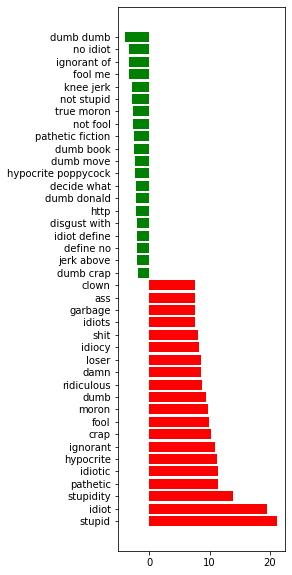

In [18]:
#create featurizer who's dictionary is based on the tfidf-vectorizers dictionary
custom_featurizer = Featurizer(foreign_features = tfidf_vectorizer.vocabulary_.copy())
train_events, train_labels = custom_featurizer.featurize(train, allow_new_features=True, verbose = True)
valid_events, valid_labels = custom_featurizer.featurize(valid, allow_new_features=False, verbose = True)

#combine outputs of tfidf and custom featurizer
train_tfidf_custom = custom_featurizer.merge_feature_matrices(tfidf_train, train_events)
valid_tfidf_custom = custom_featurizer.merge_feature_matrices(tfidf_valid, valid_events)

res = train_and_evaluate(train_tfidf_custom, train_labels, valid_tfidf_custom, valid_labels, valid_df, custom_featurizer)

In [22]:
#custom_featurizer.print_sample_with_feature_names(train_tfidf_custom, 1)
#featurizer, train_events, train_labels, valid_events, valid_labels, predicted_labels, model = res
#te = tfidf_vectorizer.transform(['He be not stupid'])
#model.predict(te)
print(nltk.word_tokenize("He can't do that!"))

['He', 'ca', "n't", 'do', 'that', '!']
